# Simple notebook to do a comparitive time series between one or more countries as well as giving a daily change in no of Corona Cases for India

In [759]:
import requests
import io 
import pandas as pd

In [760]:
# Load Corona Virus Data
url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))



In [761]:
# Function for getting data for country 
def getDataForCountry(countryName,dataFr):
    df_country = dataFr.loc[df['Country/Region'] == countryName]
    df_country = df_country.transpose()
    df_country=df_country.drop(df_country.index[[0,1,2,3]])
    df_country[countryName] =  df_country.iloc[: , 0]

    # Iterate over the sequence of column names to append
    for index in range(df_country.shape[1]-1):
       if index>0:
           df_country[countryName] =  df_country[countryName] +  df_country.iloc[: , index]
    # Remove the extra columns 
    for index in range(df_country.shape[1]-1):
        df_country.drop(df_country.columns[0], axis = 1, inplace = True) 
    return df_country;





In [762]:
# Function for getting data for country 
def getDataChangeForCountry(countryName,dataFr,days):
    df_country=getDataForCountry(countryName,dataFr).tail(days)
    df_country['New Cases-'+countryName] = df_country[countryName] - df_country[countryName].shift(1) 
    df_country['Daily Change-'+countryName] = (df_country['New Cases-'+countryName]/df_country[countryName])*100 
    return df_country;





In [763]:
# Function for getting data for Province
def getDataForProvince(provinceName,dataFr):
    df_pr = dataFr.loc[df['Province/State'] == provinceName]
    df_pr = df_pr.transpose()
    df_pr=df_pr.drop(df_pr.index[[0,1,2,3]])
    df_pr.columns=[provinceName]
    #df_pr['delta'] = df_pr[countryName] - df_pr[countryName].shift(1) 

    return df_pr;

In [764]:
def drawChartForVirus(countriesList,provinceList,log=False,delta=False):
    ax = getDataForCountry(countriesList[0],df).plot(figsize=(25,10),title="No of Confirmed Cases ",fontsize=20,logy=log,lw=4)
    # Using for loop and ignoring the first country
    count=0
    for countryName in countriesList:
        if count >0:
            getDataForCountry(countryName,df).plot(ax=ax,lw=4)
        count=count+1
    
    for provinceName in provinceList: 
        getDataForProvince(provinceName,df).plot(ax=ax,lw=4)

    ax.legend(loc=2, prop={'size': 25})
    if log:
        ax.set_title("Log -  No of Confirmed Cases", size=30)
    else:
        ax.set_title(" No of Confirmed Cases", size=30)

    return;

In [765]:
def drawDeltaChartForVirus(countriesList,percentage=False,movingAverage=False,days=30):
    
    dataFr = getDataChangeForCountry(countriesList[0],df,days)
    if not percentage:
        dataFr = dataFr.drop([countriesList[0], 'Daily Change-'+countriesList[0]], axis=1)
    else:
        dataFr = dataFr.drop([countriesList[0], 'New Cases-'+countriesList[0]], axis=1)
    
    # Currently just supported for 1 country 
    # Todo - Need to figure out a way of adding multiple country support.
    if movingAverage:
        dataFr['5 - Day Moving Avg-'+countriesList[0]] = dataFr.rolling(window=5).mean()
        ax = dataFr[['5 - Day Moving Avg-'+countriesList[0]]].plot(linestyle='-', marker='o')
        dataFr=dataFr.drop(['5 - Day Moving Avg-'+countriesList[0]], axis=1)

    
    count=0
    for countryName in countriesList:
        if count >0:
            dataFr = dataFr.merge(getDataChangeForCountry(countryName,df,days),left_index=True, right_index=True)
            if not percentage:
                dataFr = dataFr.drop([countryName, 'Daily Change-'+countryName], axis=1)
                if movingAverage:
                    dataFr['5 - Day Moving Avg-'+countryName] = dataFr['New Cases-'+countryName].rolling(window=5).mean()
            else:
                dataFr = dataFr.drop([countryName, 'New Cases-'+countryName], axis=1)
                if movingAverage:
                    dataFr['5 - Day Moving Avg-'+countryName] = dataFr['Daily Change-'+countryName].rolling(window=5).mean()
            if movingAverage:
                #dataFr['5 - Day Moving Avg-'+countryName] = dataFr[].rolling(window=5).mean()
                ax = dataFr['5 - Day Moving Avg-'+countryName].plot(linestyle='-', marker='o')
                dataFr=dataFr.drop(['5 - Day Moving Avg-'+countryName], axis=1)
        count=count+1
        #print ("Count:"+str(count))

    #print (dataFr)
    if movingAverage:
        ax=dataFr.plot(figsize=(25,(len(countriesList)*2)+10),title="No of Confirmed Cases ",fontsize=20,lw=4,kind='bar',ax=ax)
    else:
        ax=dataFr.plot(figsize=(25,10),title="No of Confirmed Cases ",fontsize=20,lw=4,kind='bar')

    ax.legend(loc=2, prop={'size': 25})
    
    #df['MA'] = df.rolling(window=5).mean()



    if percentage:
        ax.set_title("Percentage Increase -  Daily New Cases  ", size=30)
    else:
        ax.set_title("Daily New Cases ", size=30)

    return;

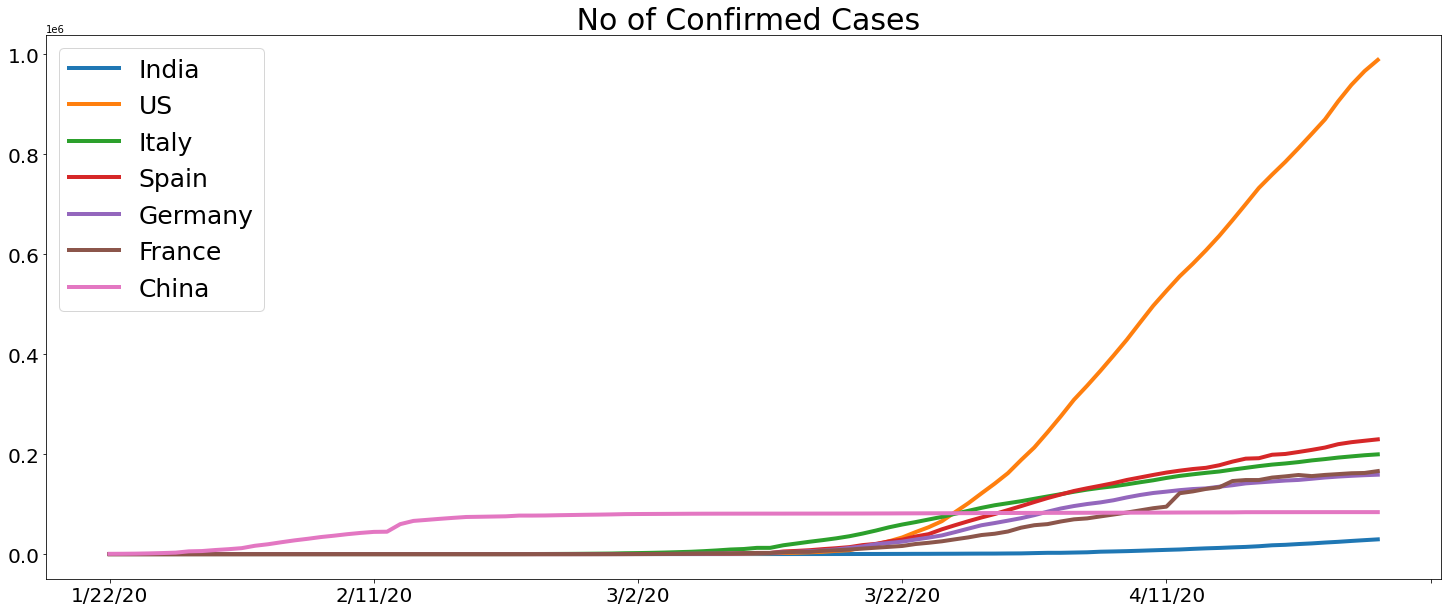

In [766]:
drawChartForVirus(["India","US","Italy","Spain","Germany","France","China"],[],False )

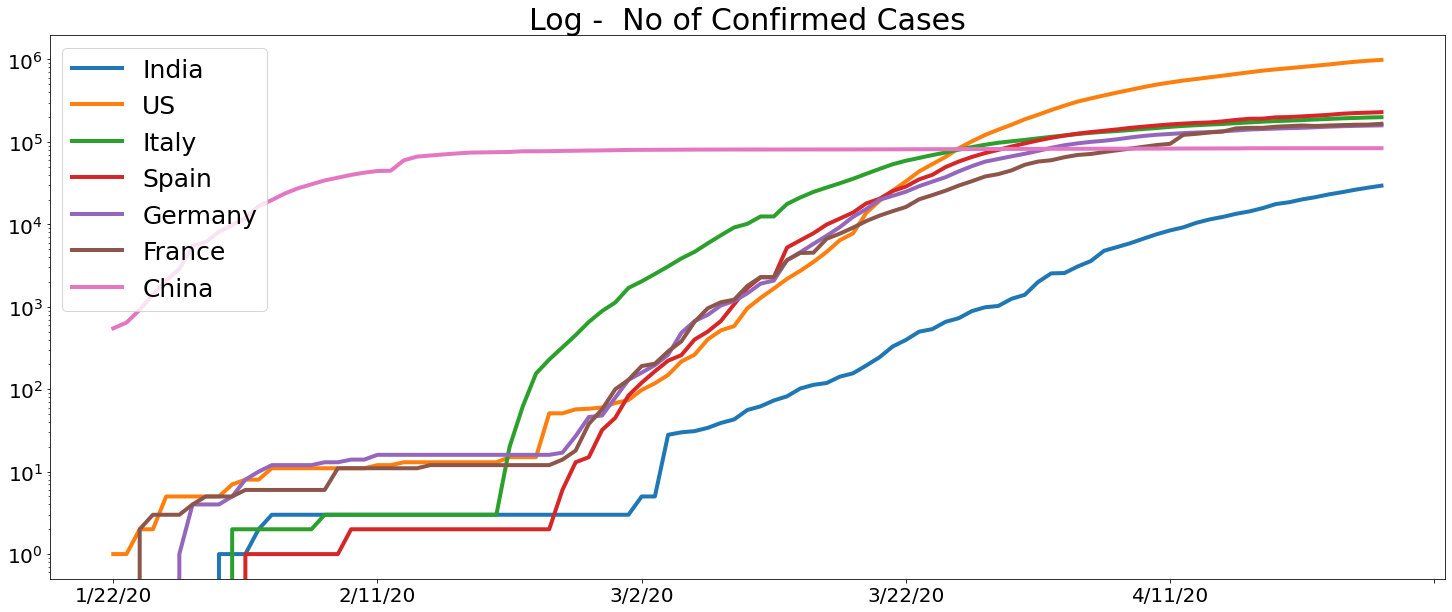

In [767]:
drawChartForVirus(["India","US","Italy","Spain","Germany","France","China"],[],True )

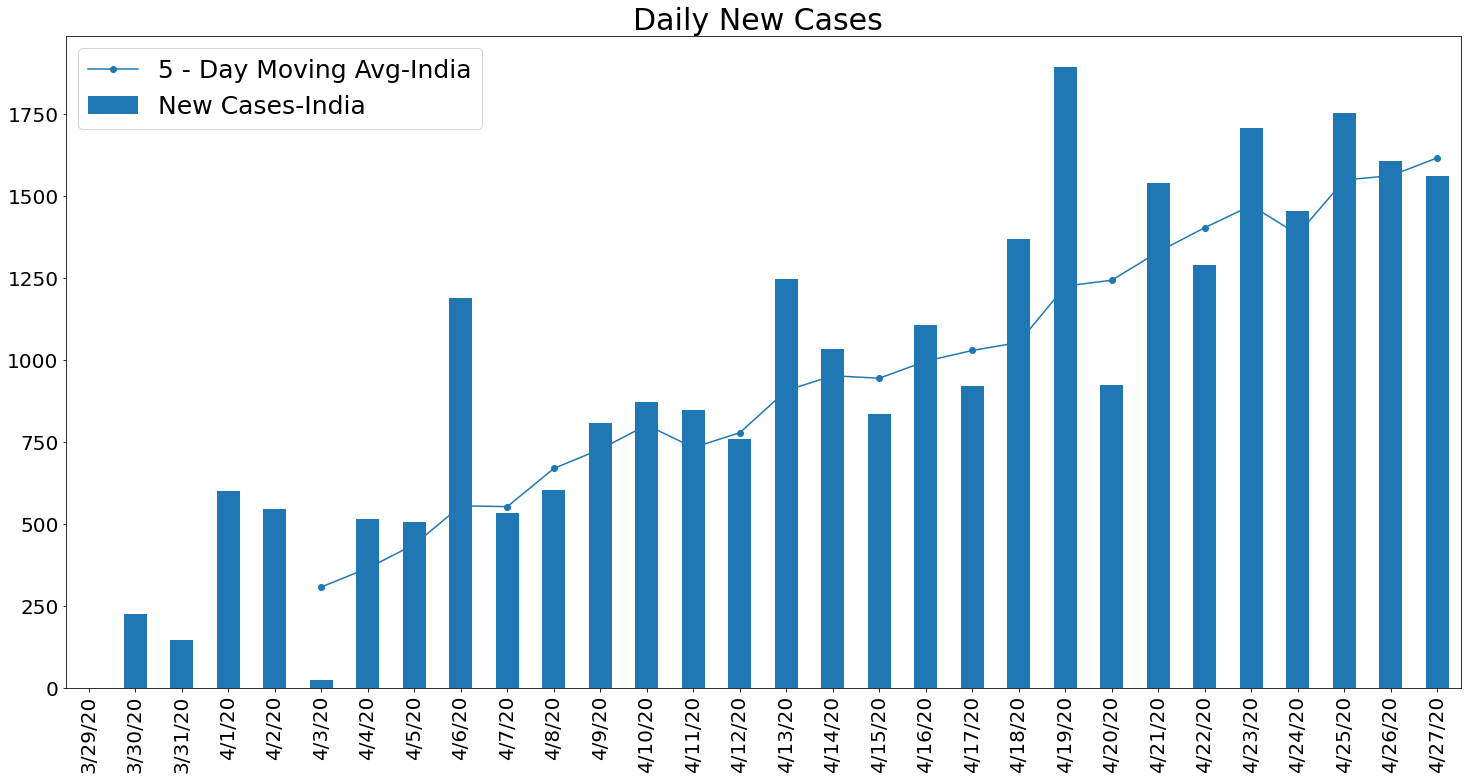

In [768]:
drawDeltaChartForVirus(["India"],False,True )

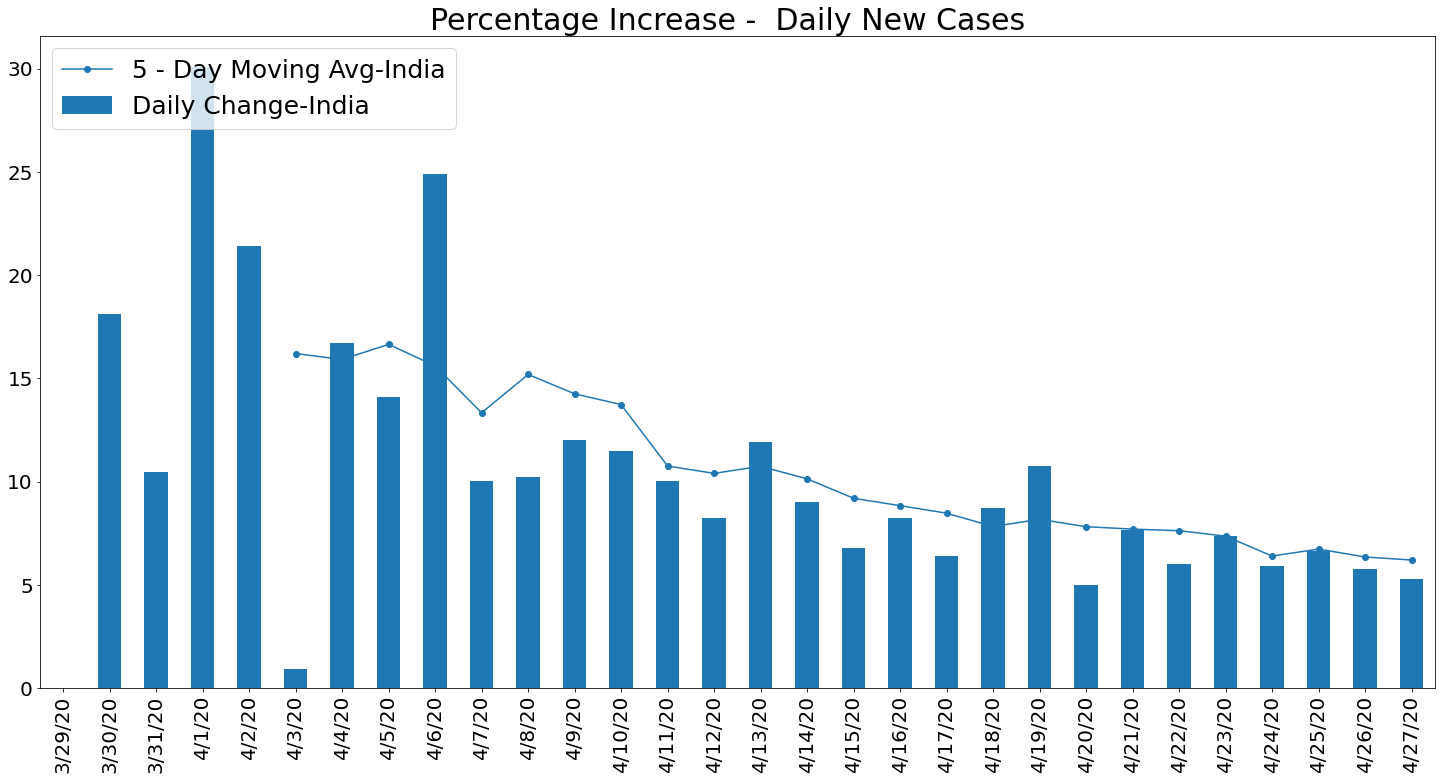

In [769]:
drawDeltaChartForVirus(["India"],True,True )

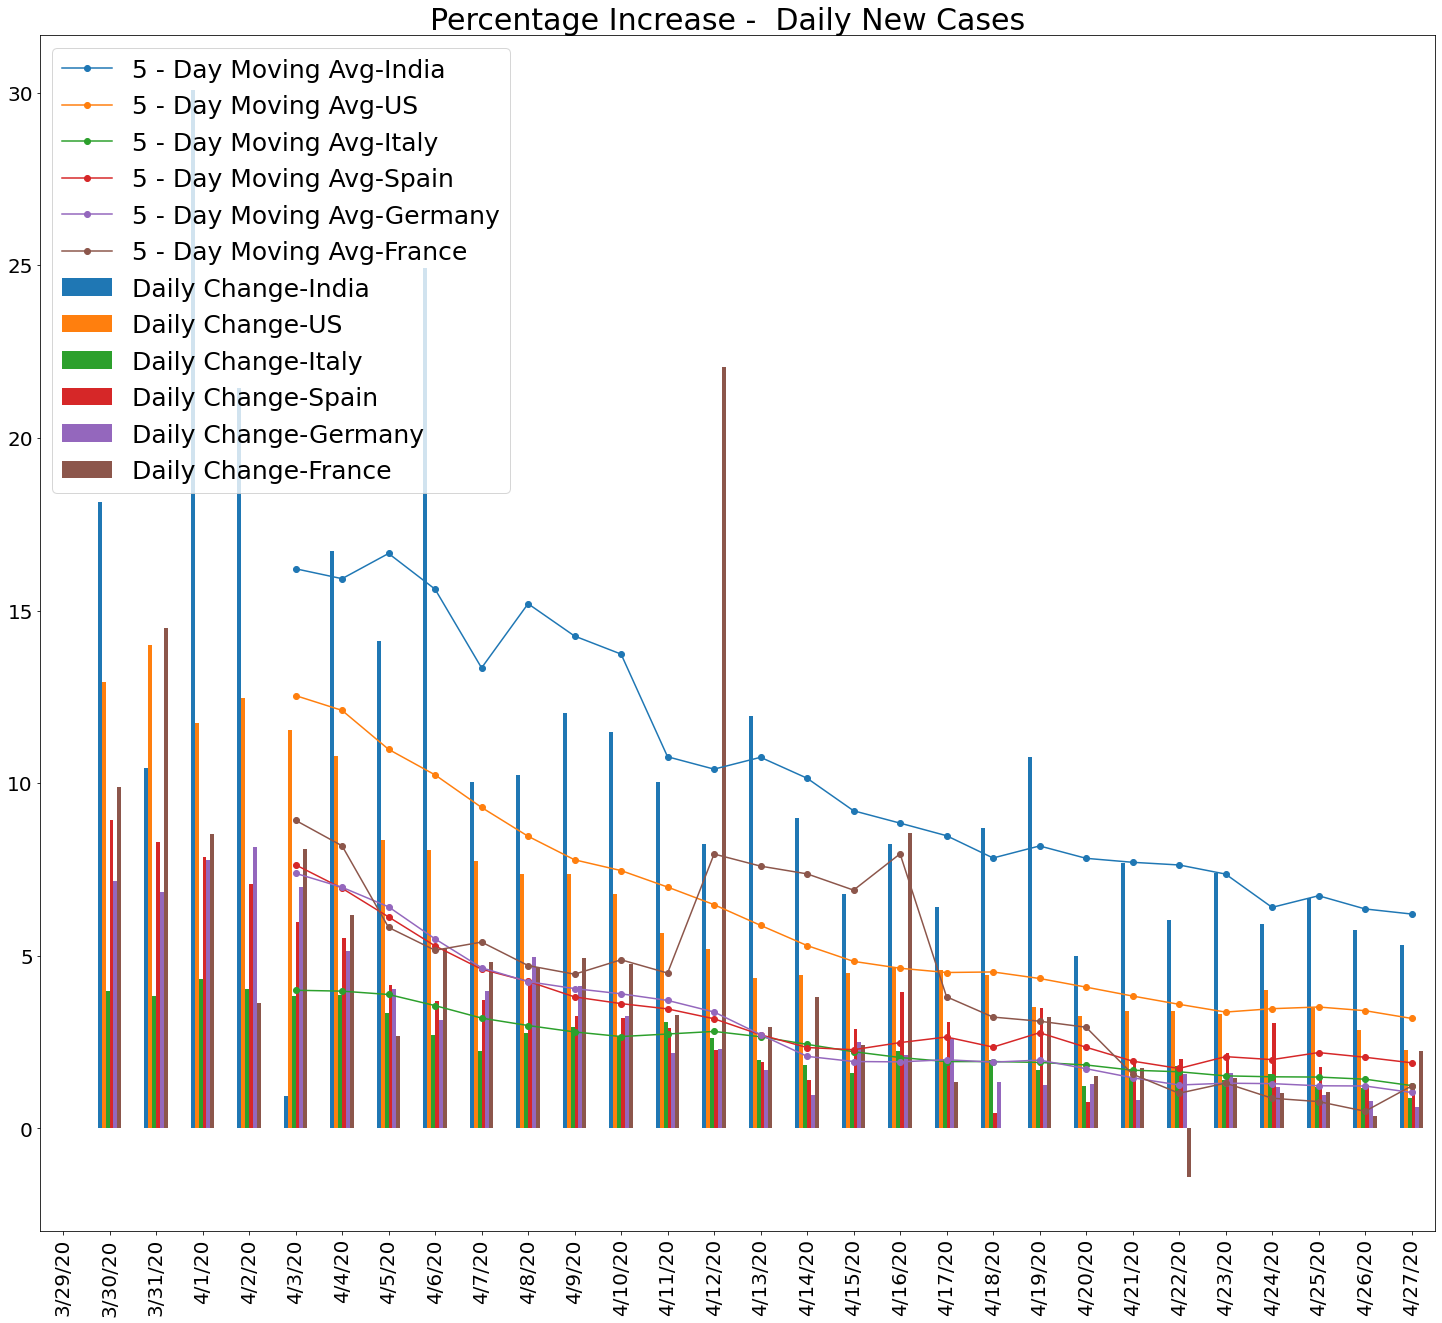

In [770]:
drawDeltaChartForVirus(["India","US","Italy","Spain","Germany","France"],True,True )

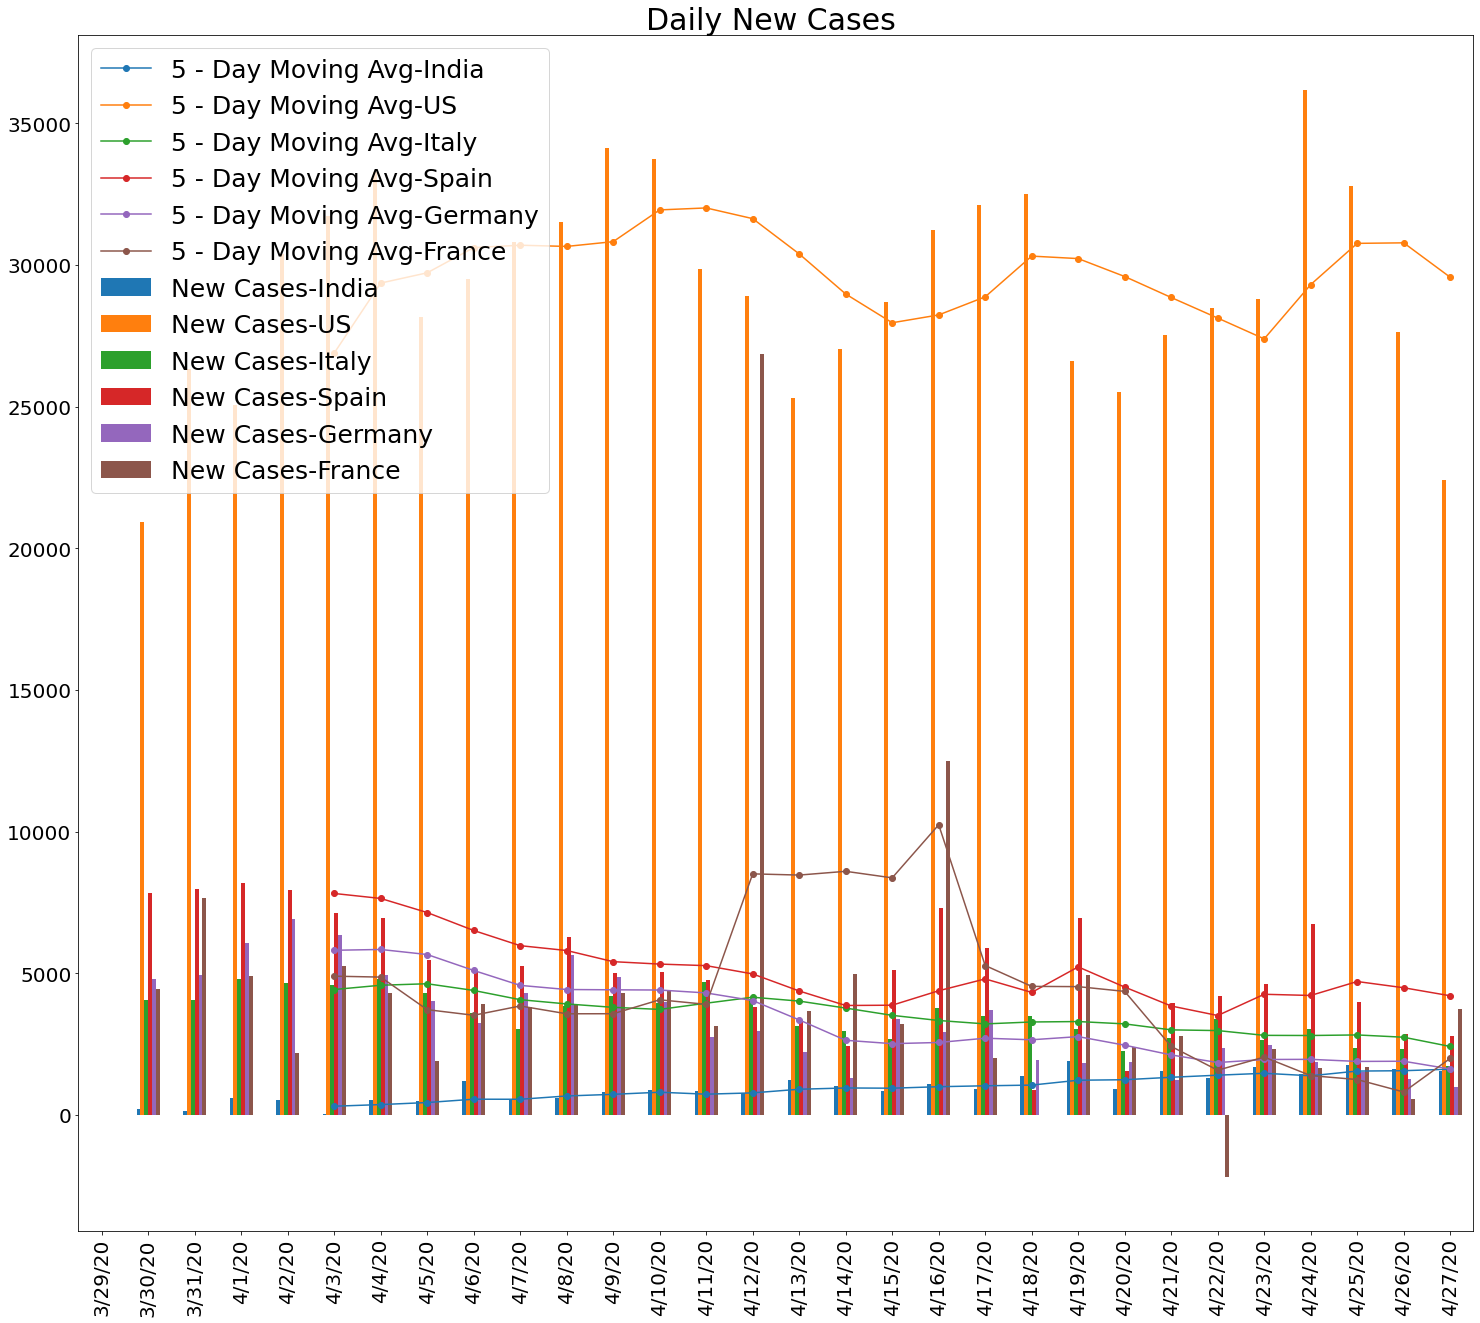

In [771]:
drawDeltaChartForVirus(["India","US","Italy","Spain","Germany","France"],False,True )